In [2]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%autoreload 2

In [4]:
import circuit_simulator as cs

In [5]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensornetwork as tn

# April 10 update

# Quick benchmark

In [6]:
noise_level = 0.01

In [7]:
# Similar code to above, but with the new definitions for sampling

In [6]:
ps = []
for x in tqdm(range(2000)):
    ps.append(cs.sample_all_qubits_faster(50, depolarizing_noise = noise_level))
ps = np.array(ps)

In [7]:
# when things are not the same
ps_nosame = []
for x in tqdm(range(2000)):
    ps_nosame.append(cs.sample_all_qubits_faster(50, all_same=False, depolarizing_noise = noise_level))
ps_nosame = np.array(ps_nosame)

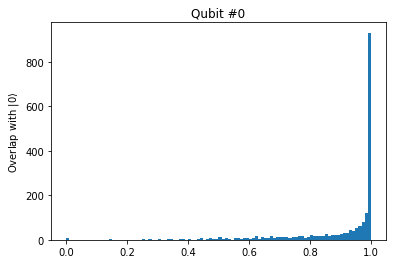

In [8]:
plt.hist(ps[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.xlabel(r"Overlap with $|0\rangle$")
plt.ylabel("Number of instances")
plt.show()

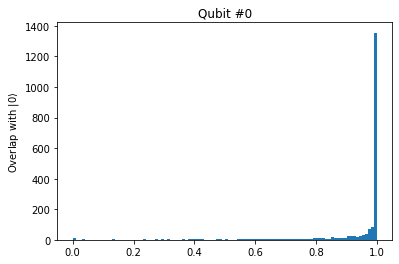

In [9]:
plt.hist(ps_nosame[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.xlabel(r"Overlap with $|0\rangle$")
plt.ylabel("Number of instances")
plt.show()

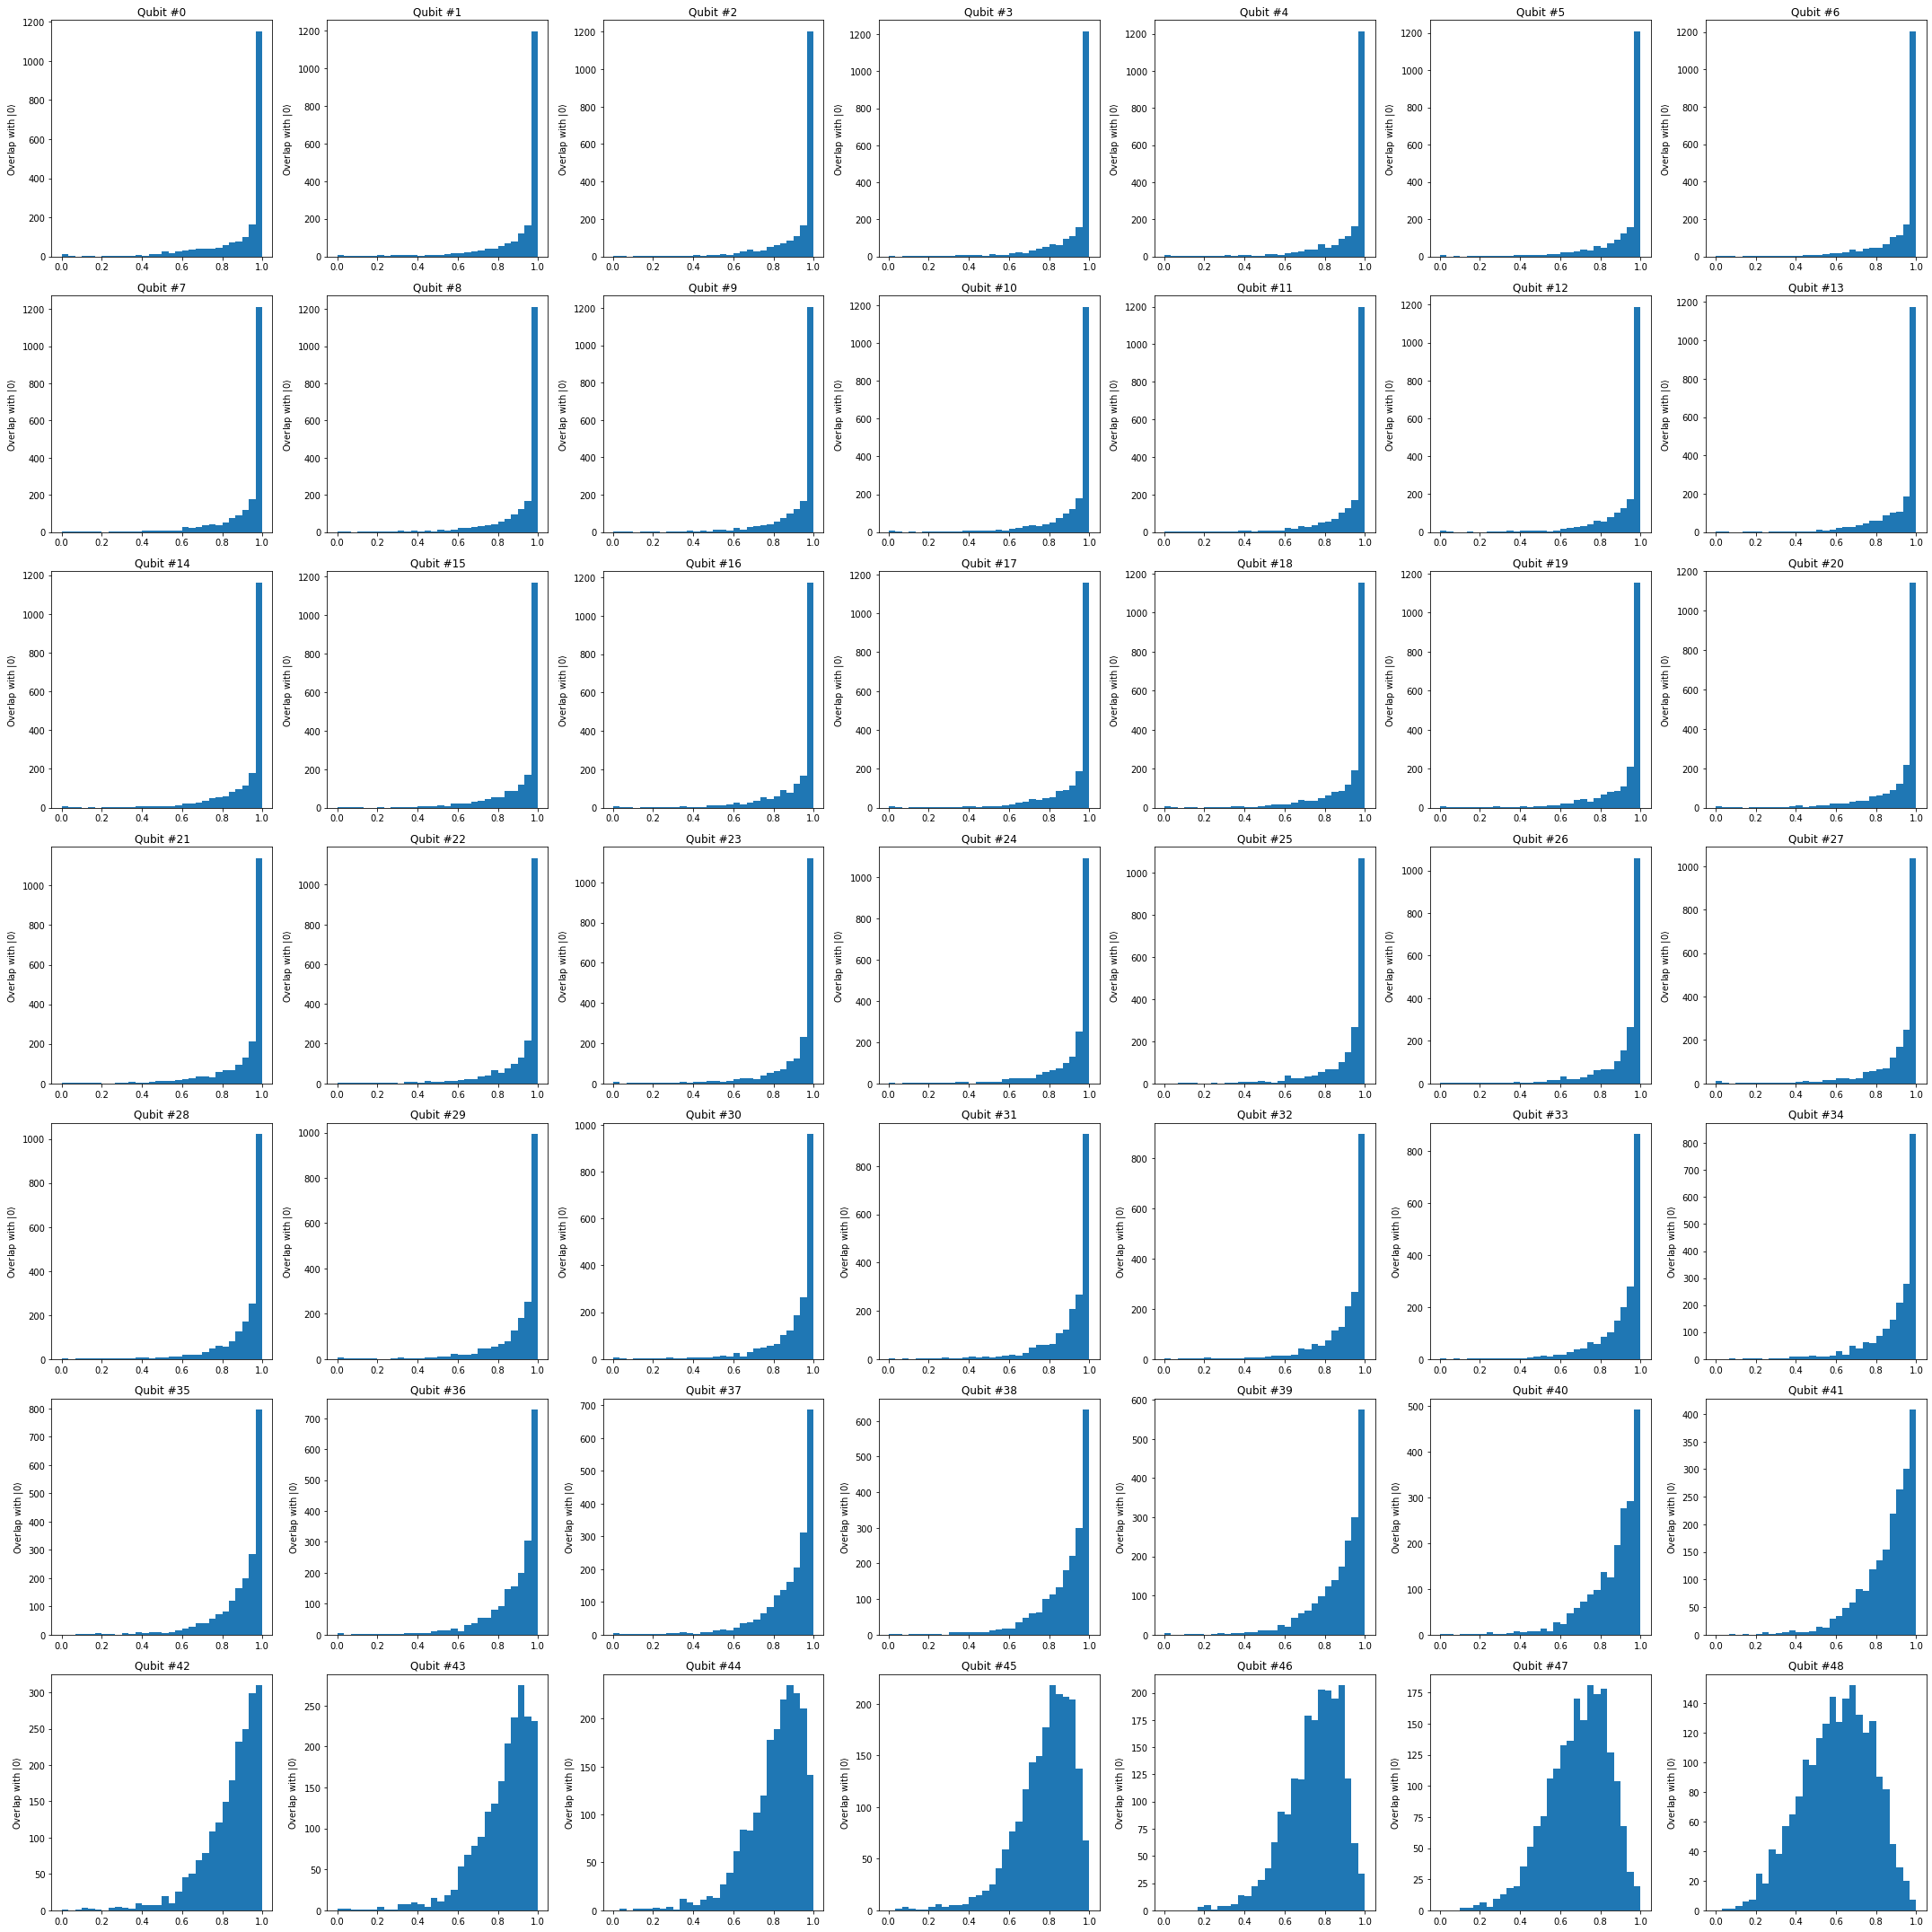

In [10]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    ax.hist(ps[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_xlabel(r"Overlap with $|0\rangle$")
    ax.set_ylabel("Number of instances")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


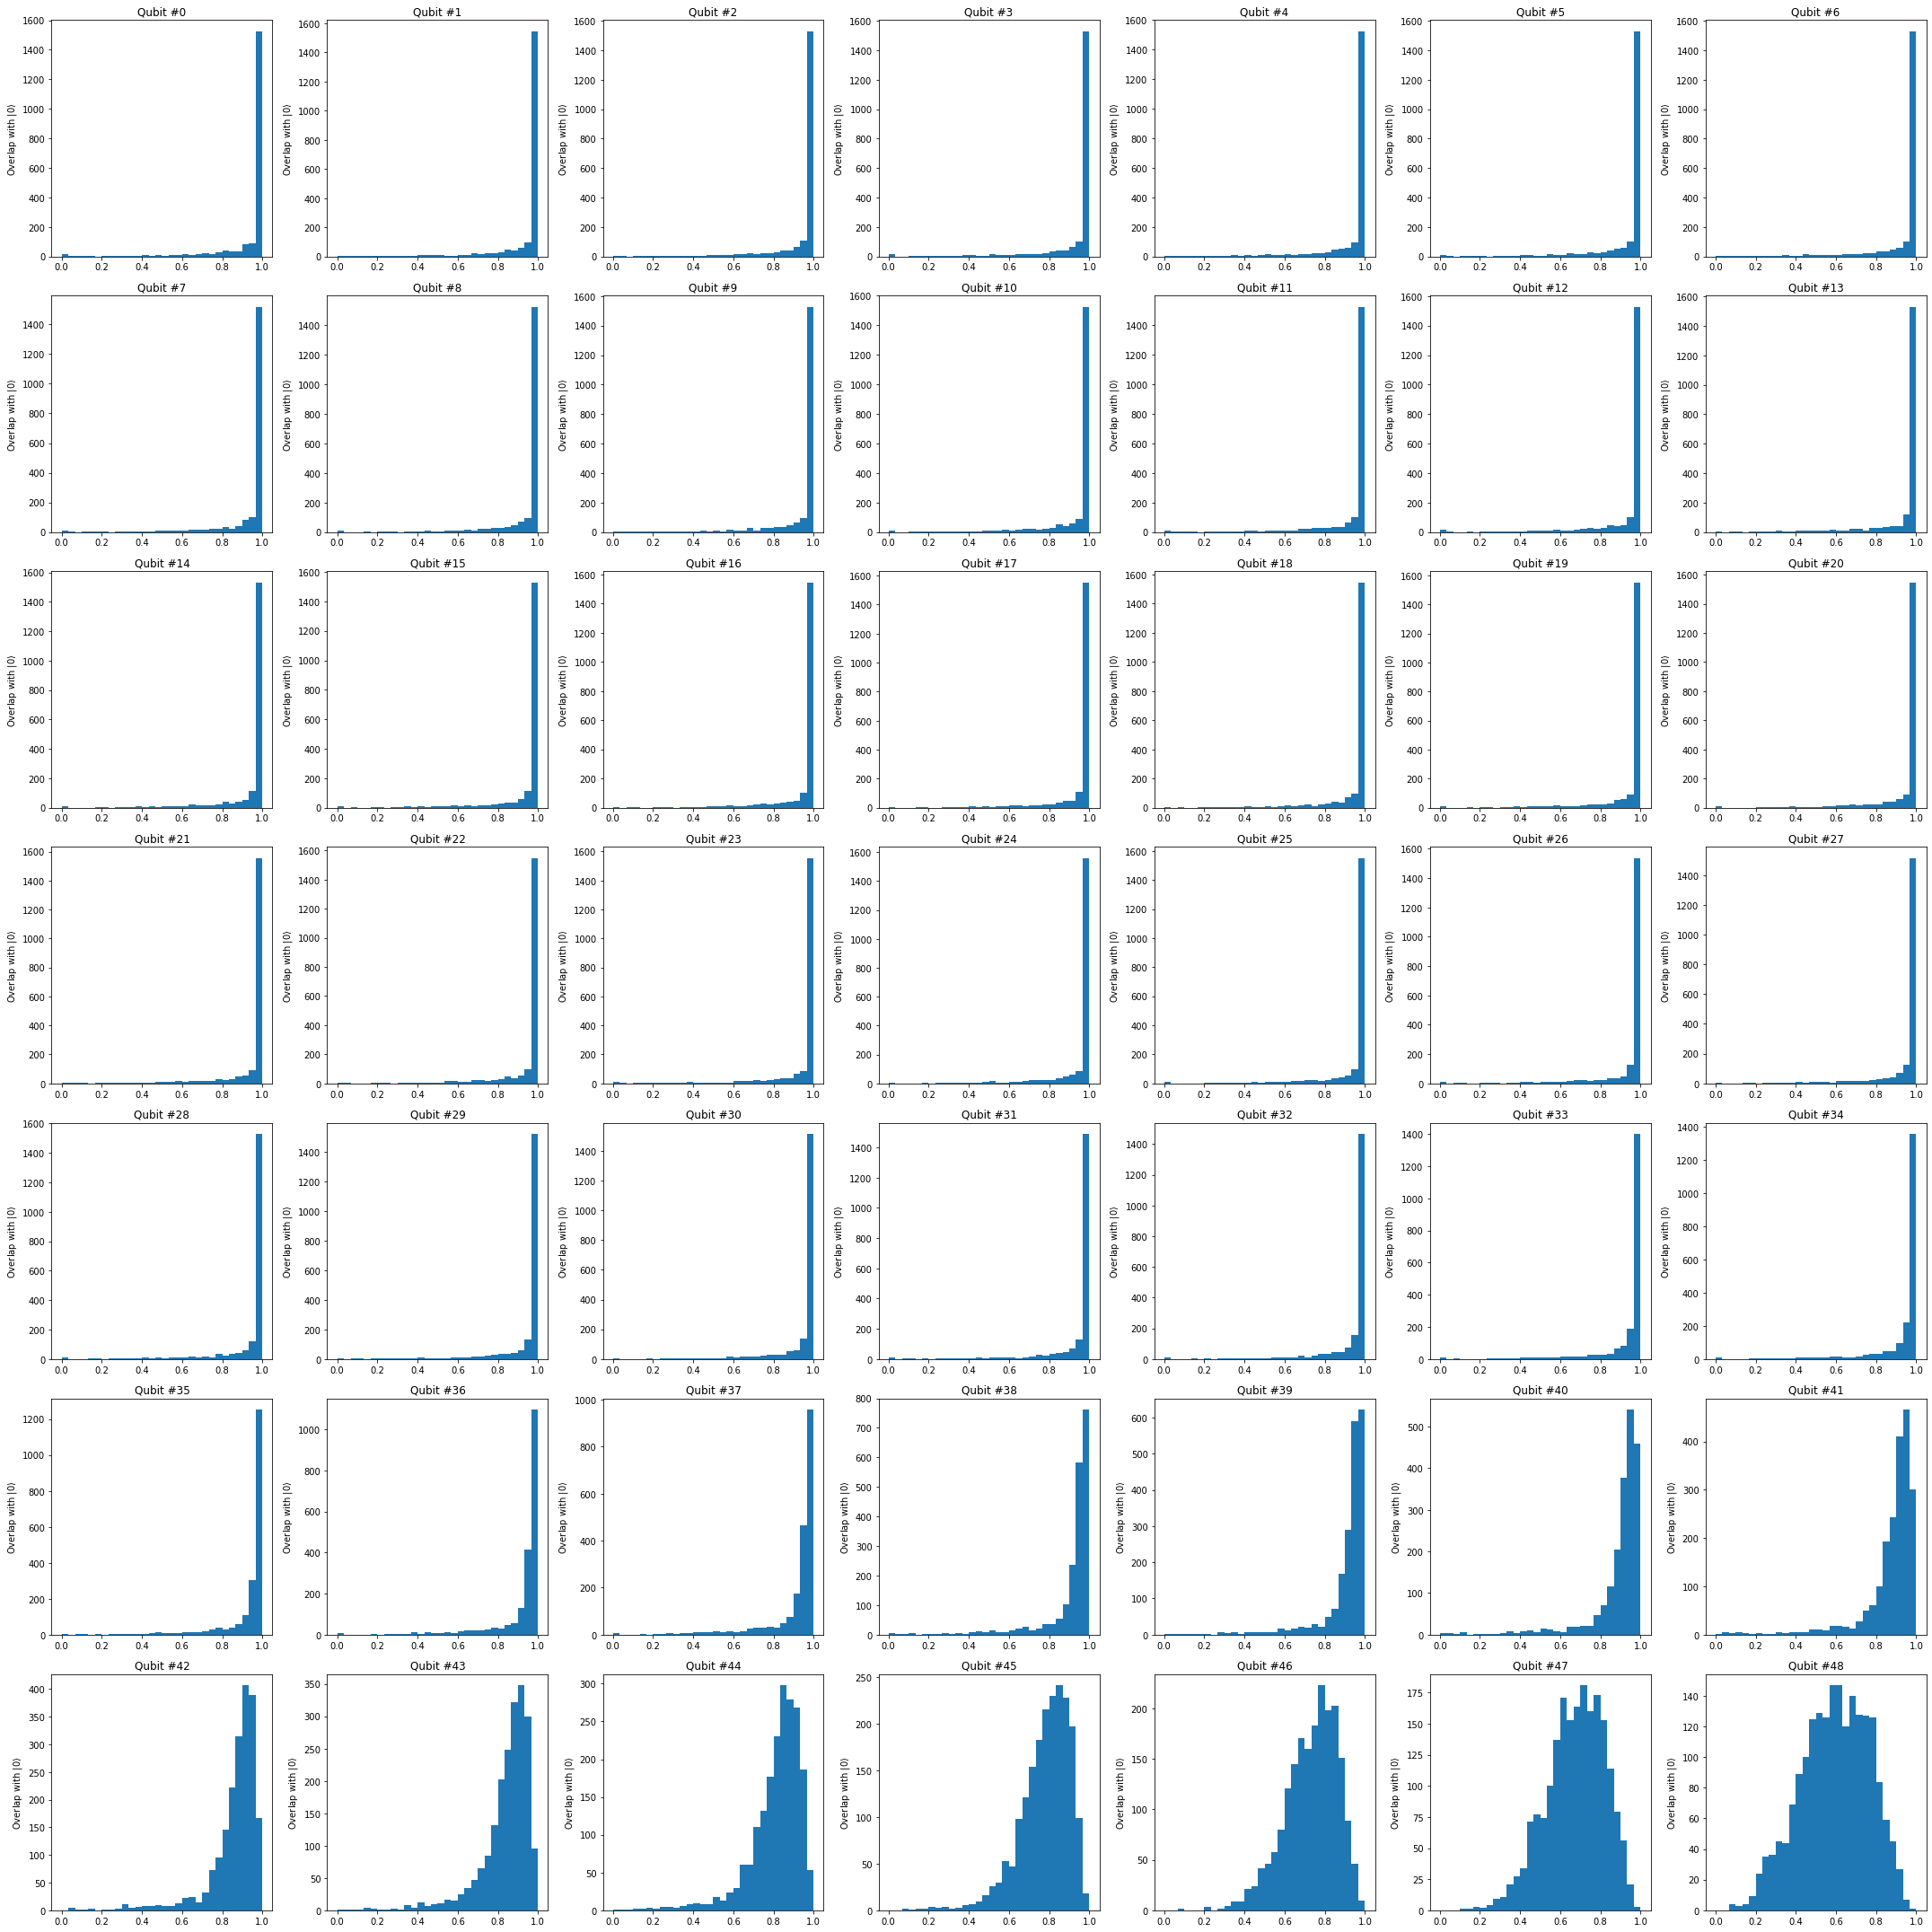

In [11]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    ax.hist(ps_nosame[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_xlabel(r"Overlap with $|0\rangle$")
    ax.set_ylabel("Number of instances")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


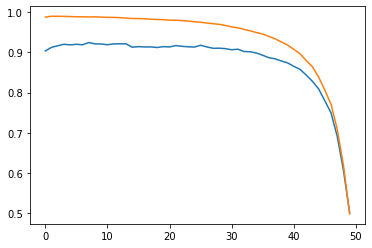

In [12]:
#blue is mean, orange is median
plt.plot(np.mean(ps,axis=0), label='Mean')
plt.plot(np.median(ps,axis=0), label='Median')
plt.legend()
plt.xlabel("Qubit number")
plt.ylabel("Mean/median overlap")
plt.title("Same random gate")
plt.show()

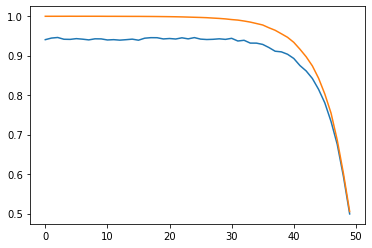

In [13]:
plt.plot(np.mean(ps_nosame,axis=0), label='Mean')
plt.plot(np.median(ps_nosame,axis=0), label='Median')
plt.legend()
plt.xlabel("Qubit number")
plt.ylabel("Mean/median overlap")
plt.title("IID random gate")
plt.show()

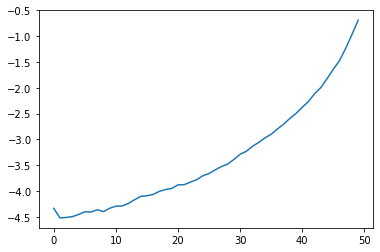

In [14]:
plt.plot(np.log(1-np.median(ps, axis=0)))
plt.xlabel("Qubit number")
plt.ylabel("1 - $\log$(mean overlap)")
plt.title("Same random gate")
plt.show()

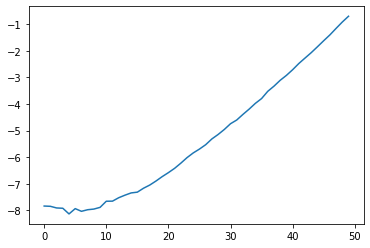

In [15]:
plt.plot(np.log(1-np.median(ps_nosame, axis=0)))
plt.xlabel("Qubit number")
plt.ylabel("1 - $\log$(mean overlap)")
plt.title("IID random gate")
plt.show()

In [16]:
# Fitting the exponential
from sklearn.linear_model import LinearRegression 

In [17]:
lr = LinearRegression()
lr.fit(np.array([np.arange(50)]).T, np.log(1-np.median(ps, axis=0)))
lr.coef_[0], lr.intercept_

(0.06770077777114794, -5.017315115764026)

In [18]:
#R2
lr.score(np.array([np.arange(50)]).T, np.log(1-np.median(ps, axis=0)))

0.9012325523812021

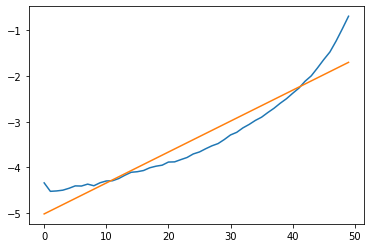

In [19]:
plt.plot(np.log(1-np.median(ps, axis=0)), legend='Data')
plt.plot(np.arange(50)*lr.coef_[0] + lr.intercept_, label='Linear fit')
plt.legend()
plt.xlabel("Qubit number")
plt.ylabel("1 - $\log$(median overlap)")
plt.title("Same random gate")

In [20]:
lr = LinearRegression()
lr.fit(np.array([np.arange(50)]).T, np.log(1-np.median(ps_nosame, axis=0)))
lr.coef_[0], lr.intercept_

(0.15786163325646013, -9.180967403707687)

In [21]:
#R2
lr.score(np.array([np.arange(50)]).T, np.log(1-np.median(ps_nosame, axis=0)))

0.9568092933238963

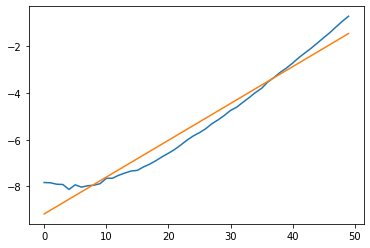

In [22]:
plt.plot(np.log(1-np.median(ps_nosame, axis=0)), label='Data')
plt.plot(np.arange(50)*lr.coef_[0] + lr.intercept_, label='Linear fit')
plt.legend()
plt.xlabel("Qubit number")
plt.ylabel("1 - $\log$(median overlap)")
plt.title("IID random gate")

# Quick benchmark but longer

In [43]:
noise_level = 0.01

In [44]:
# Similar code to above, but with the new definitions for sampling

In [58]:
from joblib import Parallel, delayed
import time

import random

def func(x):
    time.sleep(random.randint(1, 10))
    return x

def text_progessbar(seq, total=None):
    step = 1
    tick = time.time()
    while True:
        time_diff = time.time()-tick
        avg_speed = time_diff/step
        total_str = 'of %n' % total if total else ''
        print('step', step, '%.2f' % time_diff, 'avg: %.2f iter/sec' % avg_speed, total_str)
        step += 1
        yield next(seq)

all_bar_funcs = {
    'tqdm': lambda args: lambda x: tqdm(x, **args),
    'txt': lambda args: lambda x: text_progessbar(x, **args),
    'False': lambda args: iter,
    'None': lambda args: iter,
}

def ParallelExecutor(use_bar='tqdm', **joblib_args):
    def aprun(bar=use_bar, **tq_args):
        def tmp(op_iter):
            if str(bar) in all_bar_funcs.keys():
                bar_func = all_bar_funcs[str(bar)](tq_args)
            else:
                raise ValueError("Value %s not supported as bar type"%bar)
            return Parallel(**joblib_args)(bar_func(op_iter))
        return tmp
    return aprun

aprun = ParallelExecutor(n_jobs=-1)

In [59]:
n_qubits = 1000
num_samples = 100
n_times = 100

In [60]:
%%time
ps = aprun(total = num_samples,)(delayed(cs.sample_all_qubits_faster)(n_qubits, depolarizing_noise = noise_level, times = n_times) for i in range(num_samples))
ps = np.array(ps)


CPU times: user 593 ms, sys: 200 ms, total: 793 ms
Wall time: 3h 21min 26s


In [61]:
%%time
ps_nosame = aprun(total = num_samples)(delayed(cs.sample_all_qubits_faster)(n_qubits, all_same=False, depolarizing_noise = noise_level, times = n_times) for i in range(num_samples))
ps_nosame = np.array(ps_nosame)

Exception ignored in: <function tqdm.__del__ at 0x1a25fd6560>
Traceback (most recent call last):
  File "/Users/diego/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1066, in __del__
    self.close()
  File "/Users/diego/anaconda3/lib/python3.7/site-packages/tqdm/notebook.py", line 239, in close
    if self.total and self.n < self.total:
AttributeError: 'tqdm_notebook' object has no attribute 'total'


KeyboardInterrupt: 

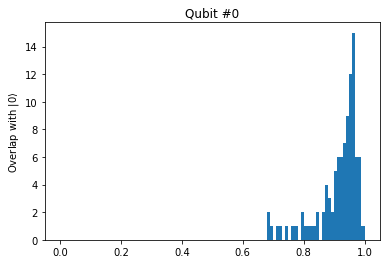

In [67]:
plt.hist(ps[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.xlabel(r"Overlap with $|0\rangle$")
plt.ylabel("Number of instances")
plt.show()

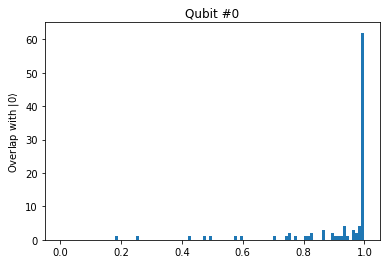

In [12]:
plt.hist(ps_nosame[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.ylabel(r"Overlap with $|0\rangle$")
plt.show()

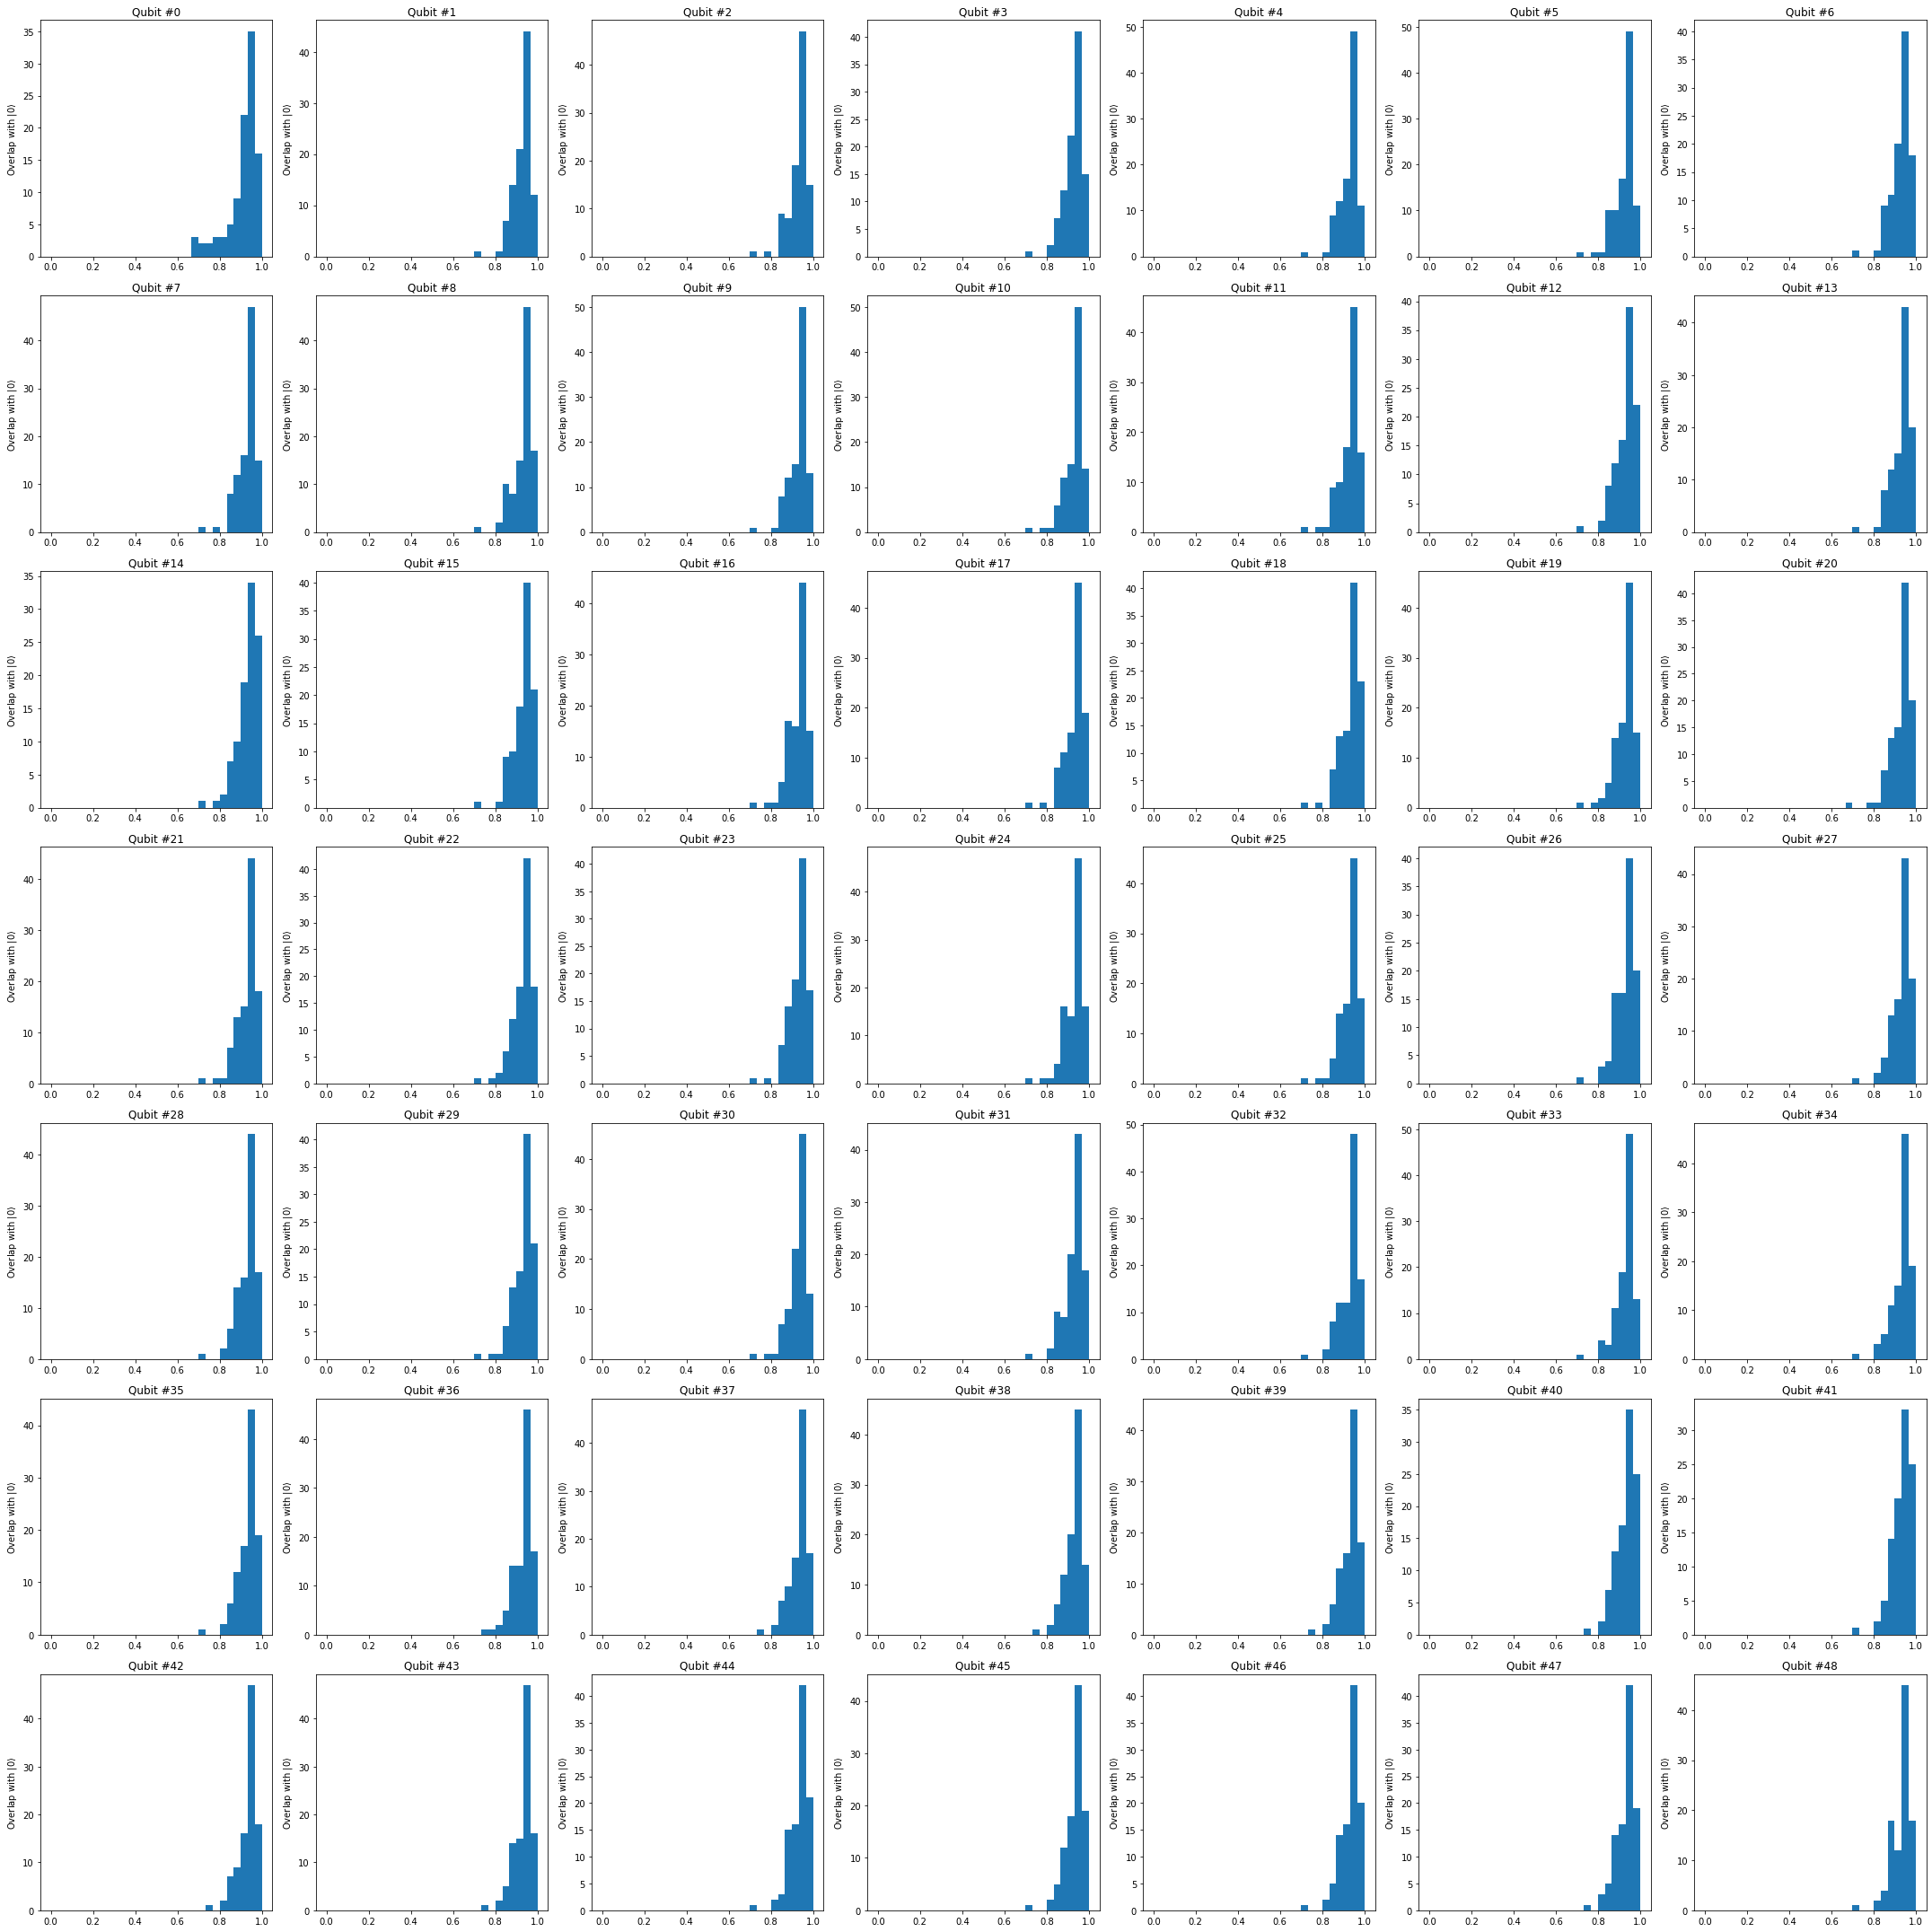

In [68]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    ax.hist(ps[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_xlabel(r"Overlap with $|0\rangle$")
    ax.set_ylabel("Number of instances")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


In [69]:
ps.shape

(100, 1000)

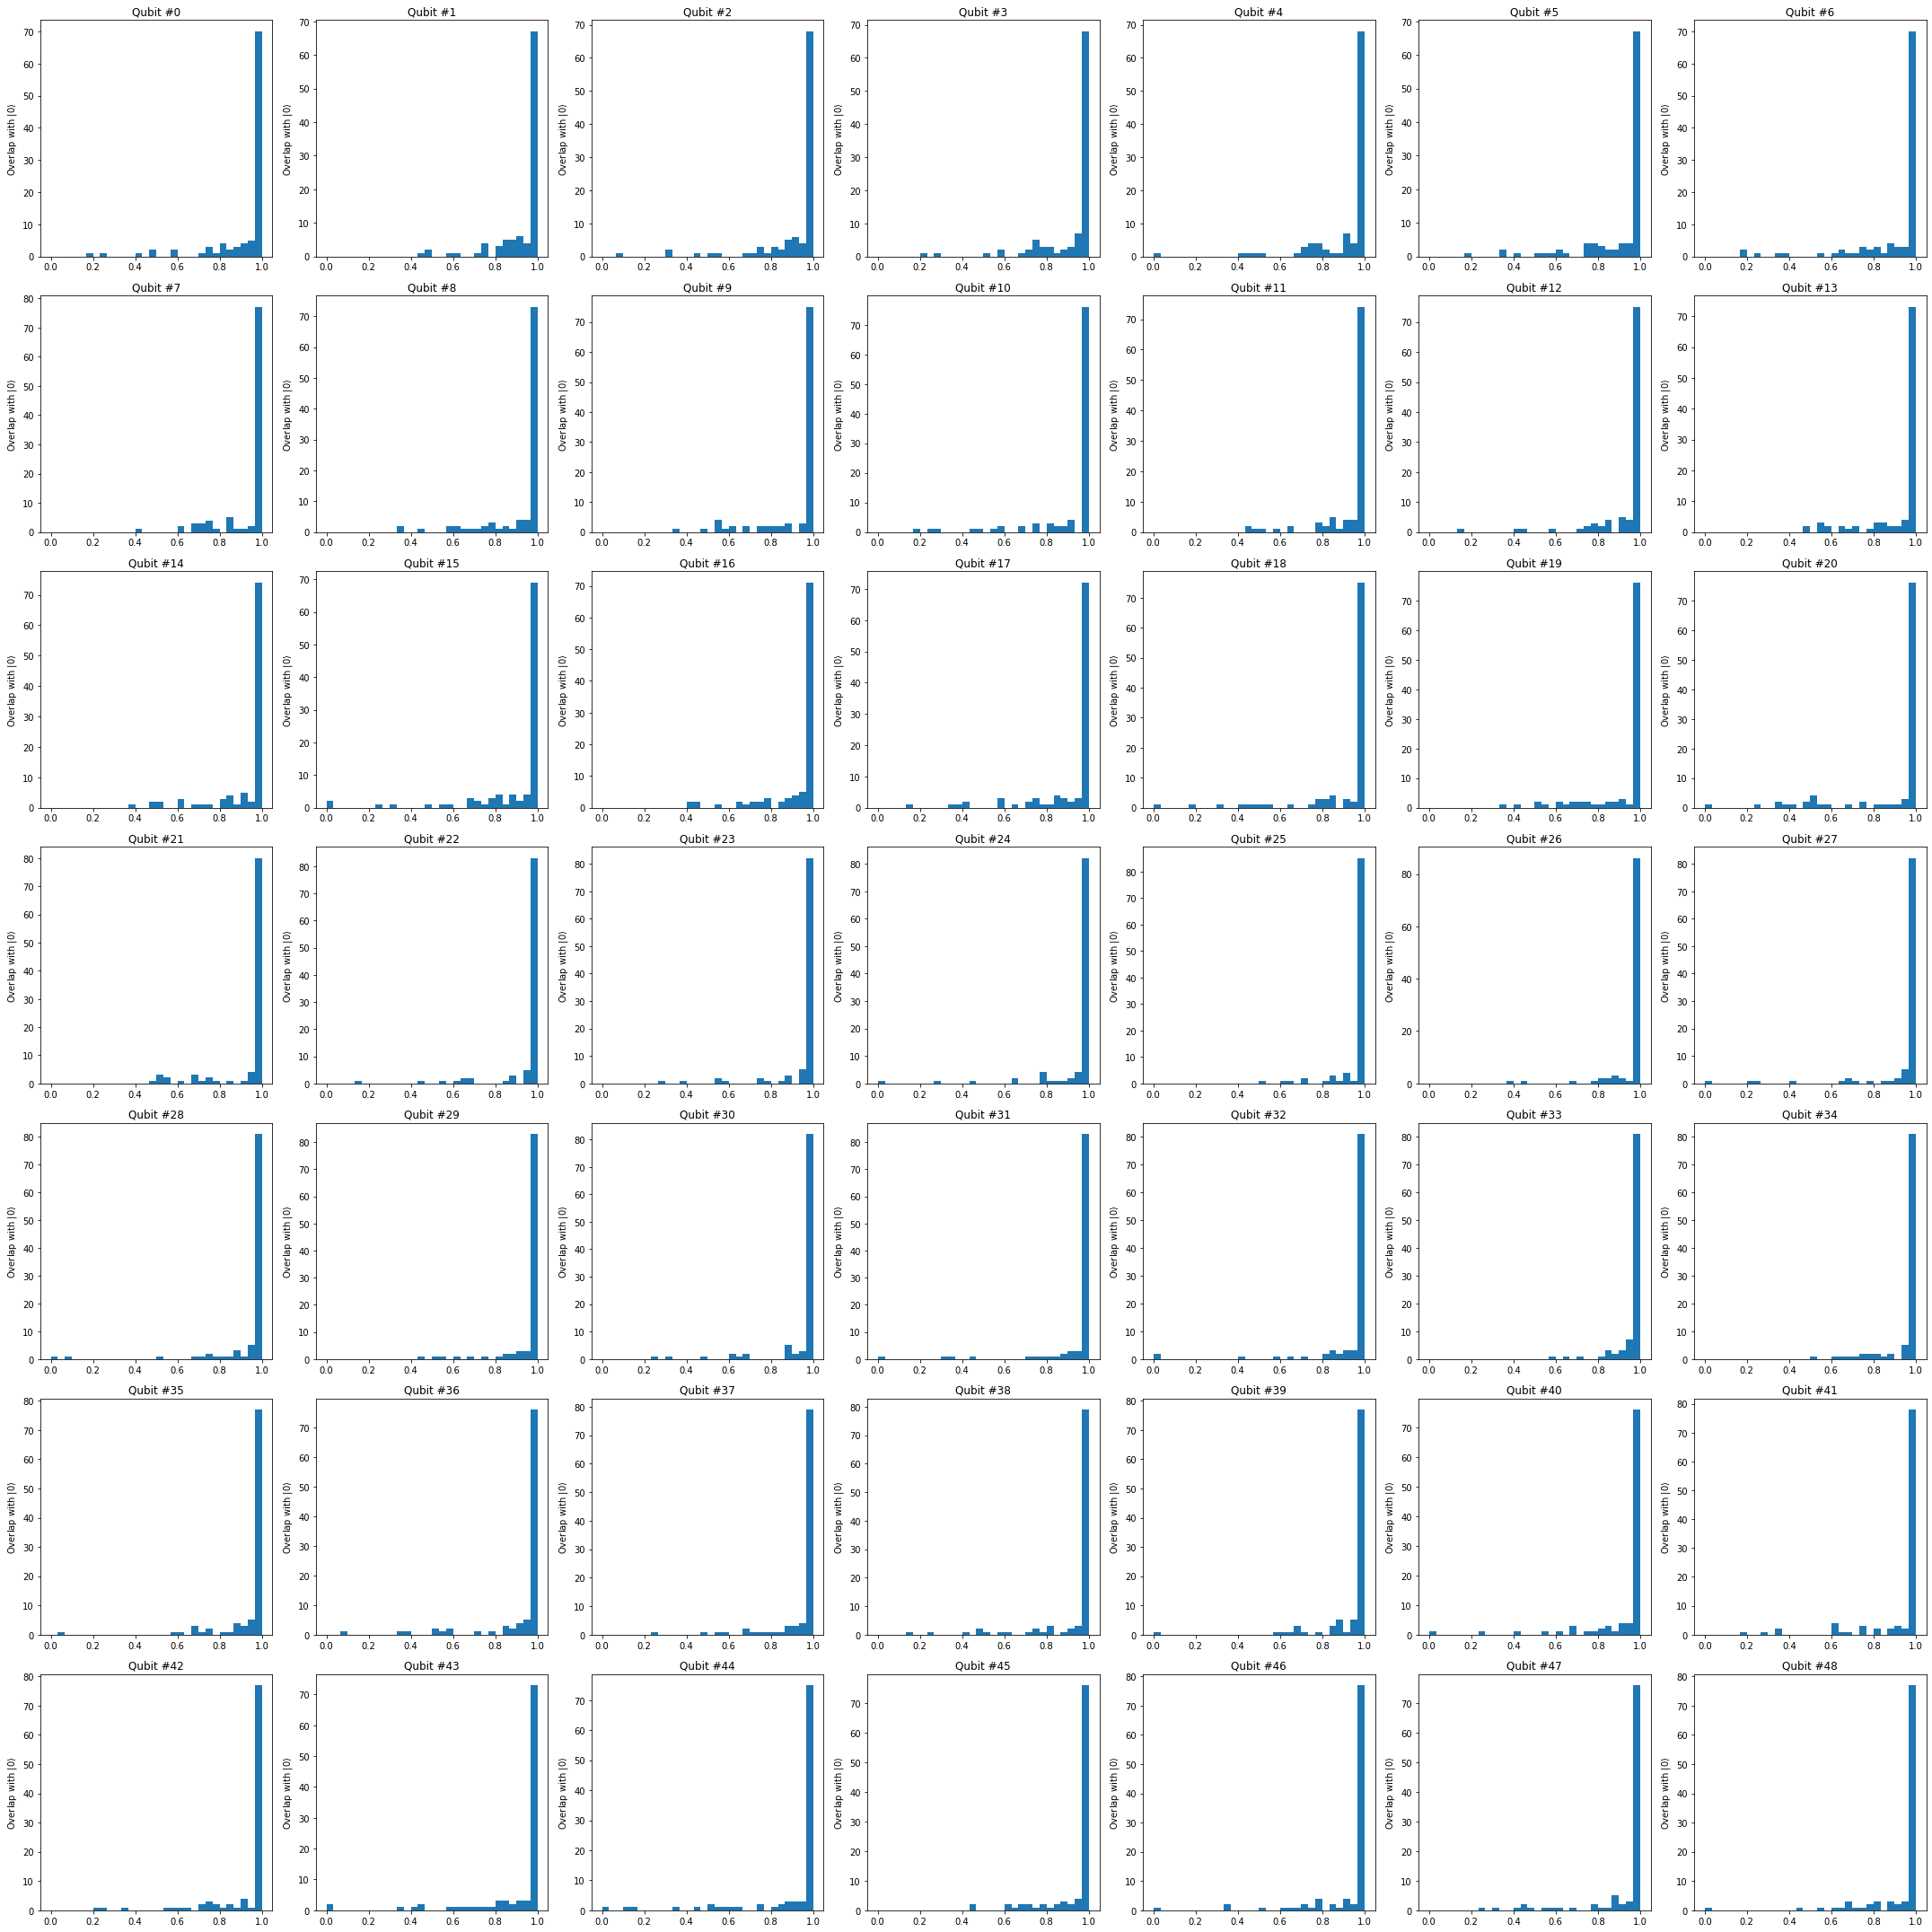

In [14]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    ax.hist(ps_nosame[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_xlabel(r"Overlap with $|0\rangle$")
    ax.set_ylabel("Number of instances")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


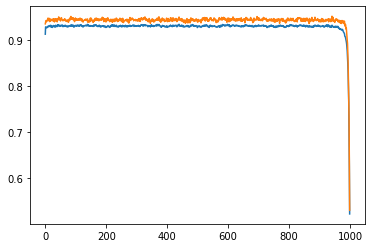

In [71]:
#blue is mean, orange is median
plt.plot(np.mean(ps,axis=0), label="Mean")
plt.plot(np.median(ps,axis=0), label="Median")
plt.legend()
plt.xlabel("Qubit number")
plt.ylabel("Overlap")
plt.title("Same random gate")
plt.show()

In [72]:
plt.plot(np.mean(ps_nosame,axis=0), label='Mean')
plt.plot(np.median(ps_nosame,axis=0), label="Median")
plt.legend()
plt.xlabel("Qubit number")
plt.ylabel("Overlap")
plt.title("IID random gate")
plt.show()

NameError: name 'ps_nosame' is not defined

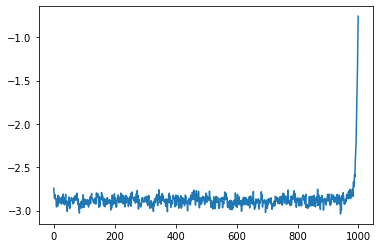

In [78]:
plt.plot(np.log(1-np.median(ps, axis=0)))
plt.xlabel("Qubit number")
plt.ylabel("1 - $\log$(median overlap)")
plt.title("Same random gate")
plt.show()

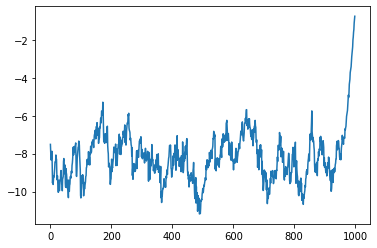

In [18]:
plt.plot(np.log(1-np.median(ps_nosame, axis=0)))
plt.xlabel("Qubit number")
plt.ylabel("1 - $\log$(median overlap)")
plt.title("IID random gate")
plt.show()

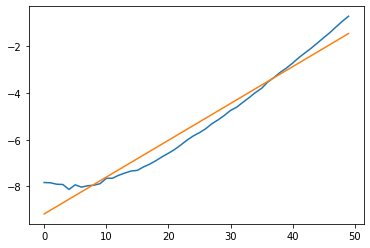

In [22]:
plt.plot(np.log(1-np.median(ps_nosame, axis=0)), label='Data')
plt.plot(np.arange(50)*lr.coef_[0] + lr.intercept_, label='Linear fit')
plt.legend()
plt.xlabel("Qubit number")
plt.ylabel("1 - $\log$(median overlap)")
plt.title("IID random gate")

In [21]:
#R2
lr.score(np.array([np.arange(50)]).T, np.log(1-np.median(ps_nosame, axis=0)))

0.9568092933238963

In [20]:
lr = LinearRegression()
lr.fit(np.array([np.arange(50)]).T, np.log(1-np.median(ps_nosame, axis=0)))
lr.coef_[0], lr.intercept_

(0.15786163325646013, -9.180967403707687)